## Computing implied volatility for equity index options

Here we show how to compute prices, greeks, and implied volatilities from
a chain of equity index options.


In [1]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import ez_bsm.asay as fiv

In [2]:
# Load a set of (almost) mid prices for index options for 02/21/2018.
# Tgt is the price of the option for imp vol calibration.
# Prices have been massaged slightly so as not to republish
# exchange data.

# Interest rates are 3m Libor.
# The dividend yield was estimated according to
# the methodology suggested by optionmetrics.

df = pd.read_csv('OptionChainAsay_20180221.csv')
print('Total number of contracts:', df.shape)
print('Days to expiration:', df.dte.unique())

df.sort_values('volume').tail()

Total number of contracts: (1993, 10)
Days to expiration: [  24   59   87  115  213  304  332  388  486  668 1032]


,type,is_call,strike,dte,int_rate,div_yld,underlying_spot,tgt,volume,openinterest
84,call,True,2800,24,0.019198,0.01707,2701.39,5.30,12032,108399
203,put,False,2710,24,0.019198,0.01707,2701.39,47.35,12975,15178
73,call,True,2745,24,0.019198,0.01707,2701.39,18.50,15916,22232
81,call,True,2785,24,0.019198,0.01707,2701.39,7.60,16429,20841
181,put,False,2600,24,0.019198,0.01707,2701.39,18.55,20390,90489


In [3]:
# define some columns we will need later
df['tau'] = df.dte / 365.
df['discount_factor'] = np.exp(-df.tau * df.int_rate)
df['underlying_fwd'] = df.underlying_spot * np.exp(df.tau * (df.int_rate - df.div_yld)) 

# need to convert spot option prices to expiry forwards to use the Asay model
df['tgt_fwd'] = df.tgt / df.discount_factor


In [4]:
# compute implied volatilities
df['computed_iv'] = fiv.safe_compute_iv(tgt=df.tgt_fwd, 
                                        fwd=df.underlying_fwd, 
                                        strike=df.strike, 
                                        tau=df.tau, 
                                        is_call=df.is_call)

greeks = fiv.greeks_from(fwd=df.underlying_fwd, 
                         strike=df.strike, 
                         tau=df.tau, 
                         sigma=df.computed_iv, 
                         is_call=df.is_call)
df['delta'] = greeks['delta']
df['abs_delta'] = greeks['abs_delta']

# make sure pricing errors are uniformly small 
assert np.abs(df.tgt_fwd - greeks['price']).max() < 1e-10


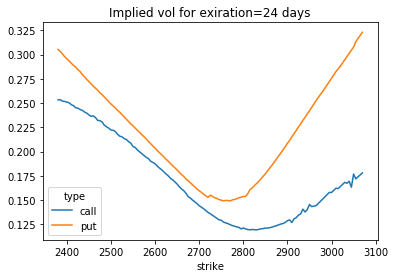

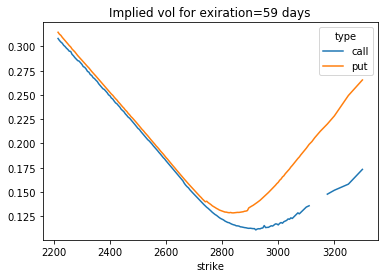

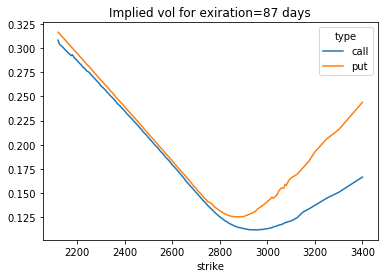

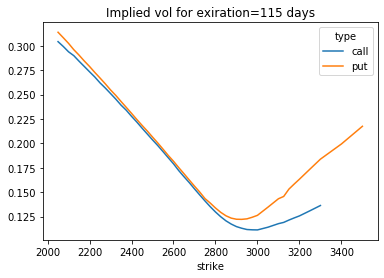

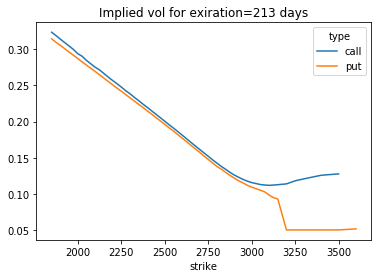

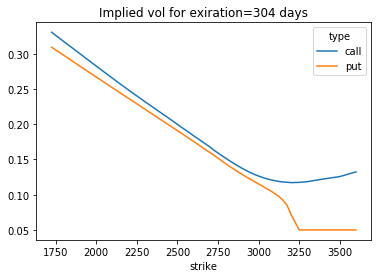

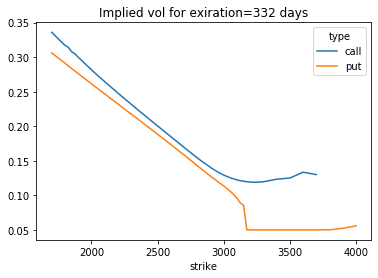

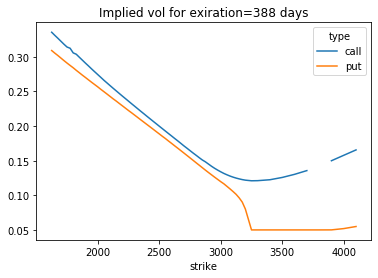

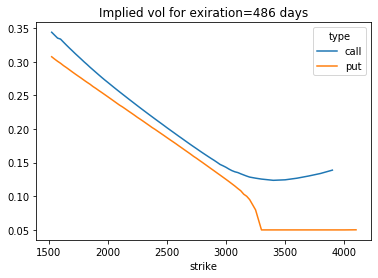

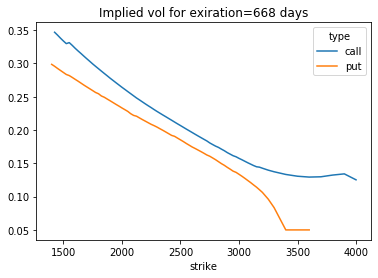

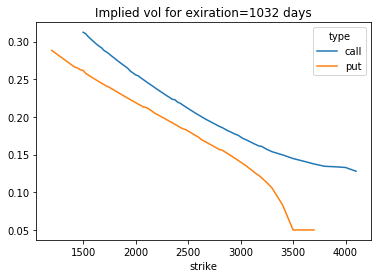

In [5]:
# plot implied vol, one per maturity
gb = df.groupby('dte')
for dte,ff in gb:
    (ff.pivot('strike','type','computed_iv')
       .plot(title=f'Implied vol for exiration={dte} days'));

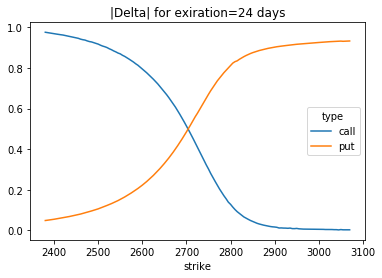

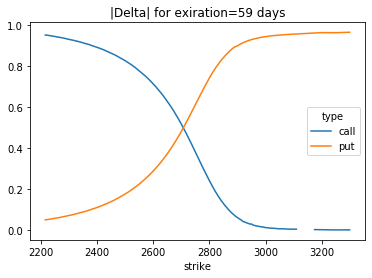

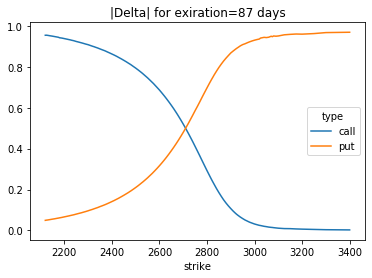

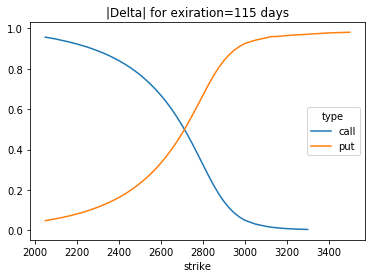

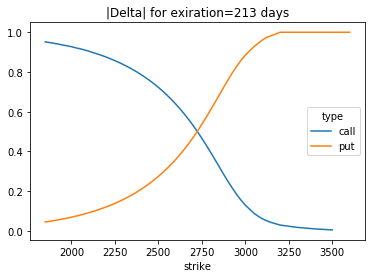

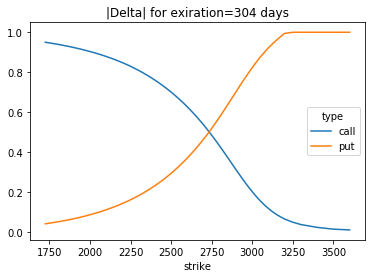

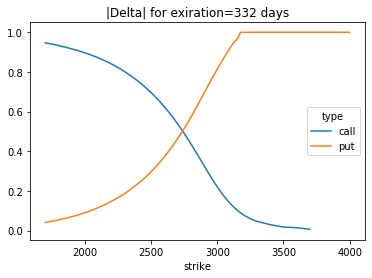

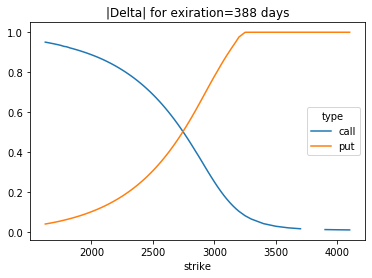

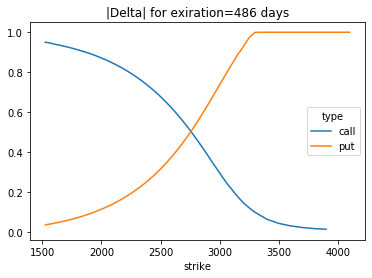

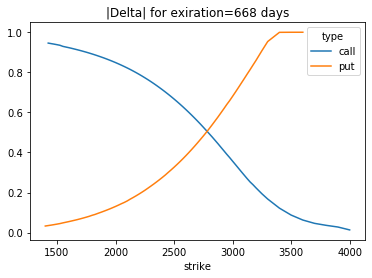

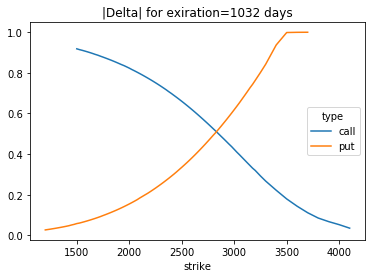

In [6]:
# plot abs(forward delta), one per maturity

gb = df.groupby('dte')
for dte,ff in gb:
    (ff.pivot('strike','type','abs_delta')
       .plot(title=f'|Delta| for exiration={dte} days'));